# Introduction

Manga & Anime dataset 2024, link: https://www.kaggle.com/datasets/duongtruongbinh/manga-and-anime-dataset

## Problem

As people who enjoy reading manga and watching anime, we often ask ourselves the question; why do some manga succeed, when others don't? Many times it seems like long running manga series, that are somewhat of a staple in the community, just continue to reap success even though they have long ago lost any resemblance of creativity. Meanwhile new up and coming series, which often actually include fresh and new creative ideas, many times fail to establish themselves and dont renew for more seasons or chapters. Often it seems that the longer a manga series is ongoing, the more likely it is to succeed. 

Thus, the problem is simple. If a new manga is to establish itself, how would it maximize it's chances of success? Will adding more chapters give a better audience reception? Also, which genre is most likely to succeed, and should thus be chosen by the new manga series trying to establish itself?

## Hypothesis

Adding more chapters will give the new manga a better audience reception.

## Strategy

In order to determine the hypothesis is true we first need to establish what metrics it is that we are measuring. Audience perception is the same as its overall popularity, score and rankning compared to other manga. It would thus seem appropriate to measure this with Score, Popularity and Rank from our dataset. We also need to keep in mind the total number of votes for each manga, because a low number of ratings (but each is extraordinarily high) on for example the score could lead to a skewed picture of the actual score compared to a manga with millions of ratings on score. Regarding the genre we need to determine a few things. Which is the most popular genre? Is there any overall trends that could affect the choice of manga? Is there any major difference regarding the main hypothesis for different genres?

What we need to examine is hence:
* Score based on Chapters
* Popularity based on Chapters
* Rank based on Chapters
* Take number of votes into account, for example by filtering out outliers of the other metrics that have a low number of votes.
* All of the above but for the main genres to examine of different genres favour different amount of chapters
* Current trends in genre popularity, etc, to examine if there is any merit to not chosing the most popular genre (for example if it's popularity is in decline or if one genre has drastically lower average ratings than others)



# Data Analysis

Firstly the main components that will be used during the data analysis must be imported. These are Matplotlib, Numpy and Pandas.

In [38]:
# General imports needed for the data analysis
import matplotlib.pyplot as mpl
import numpy as np
import pandas as pd

Text(0.5, 0, 'Chapters')

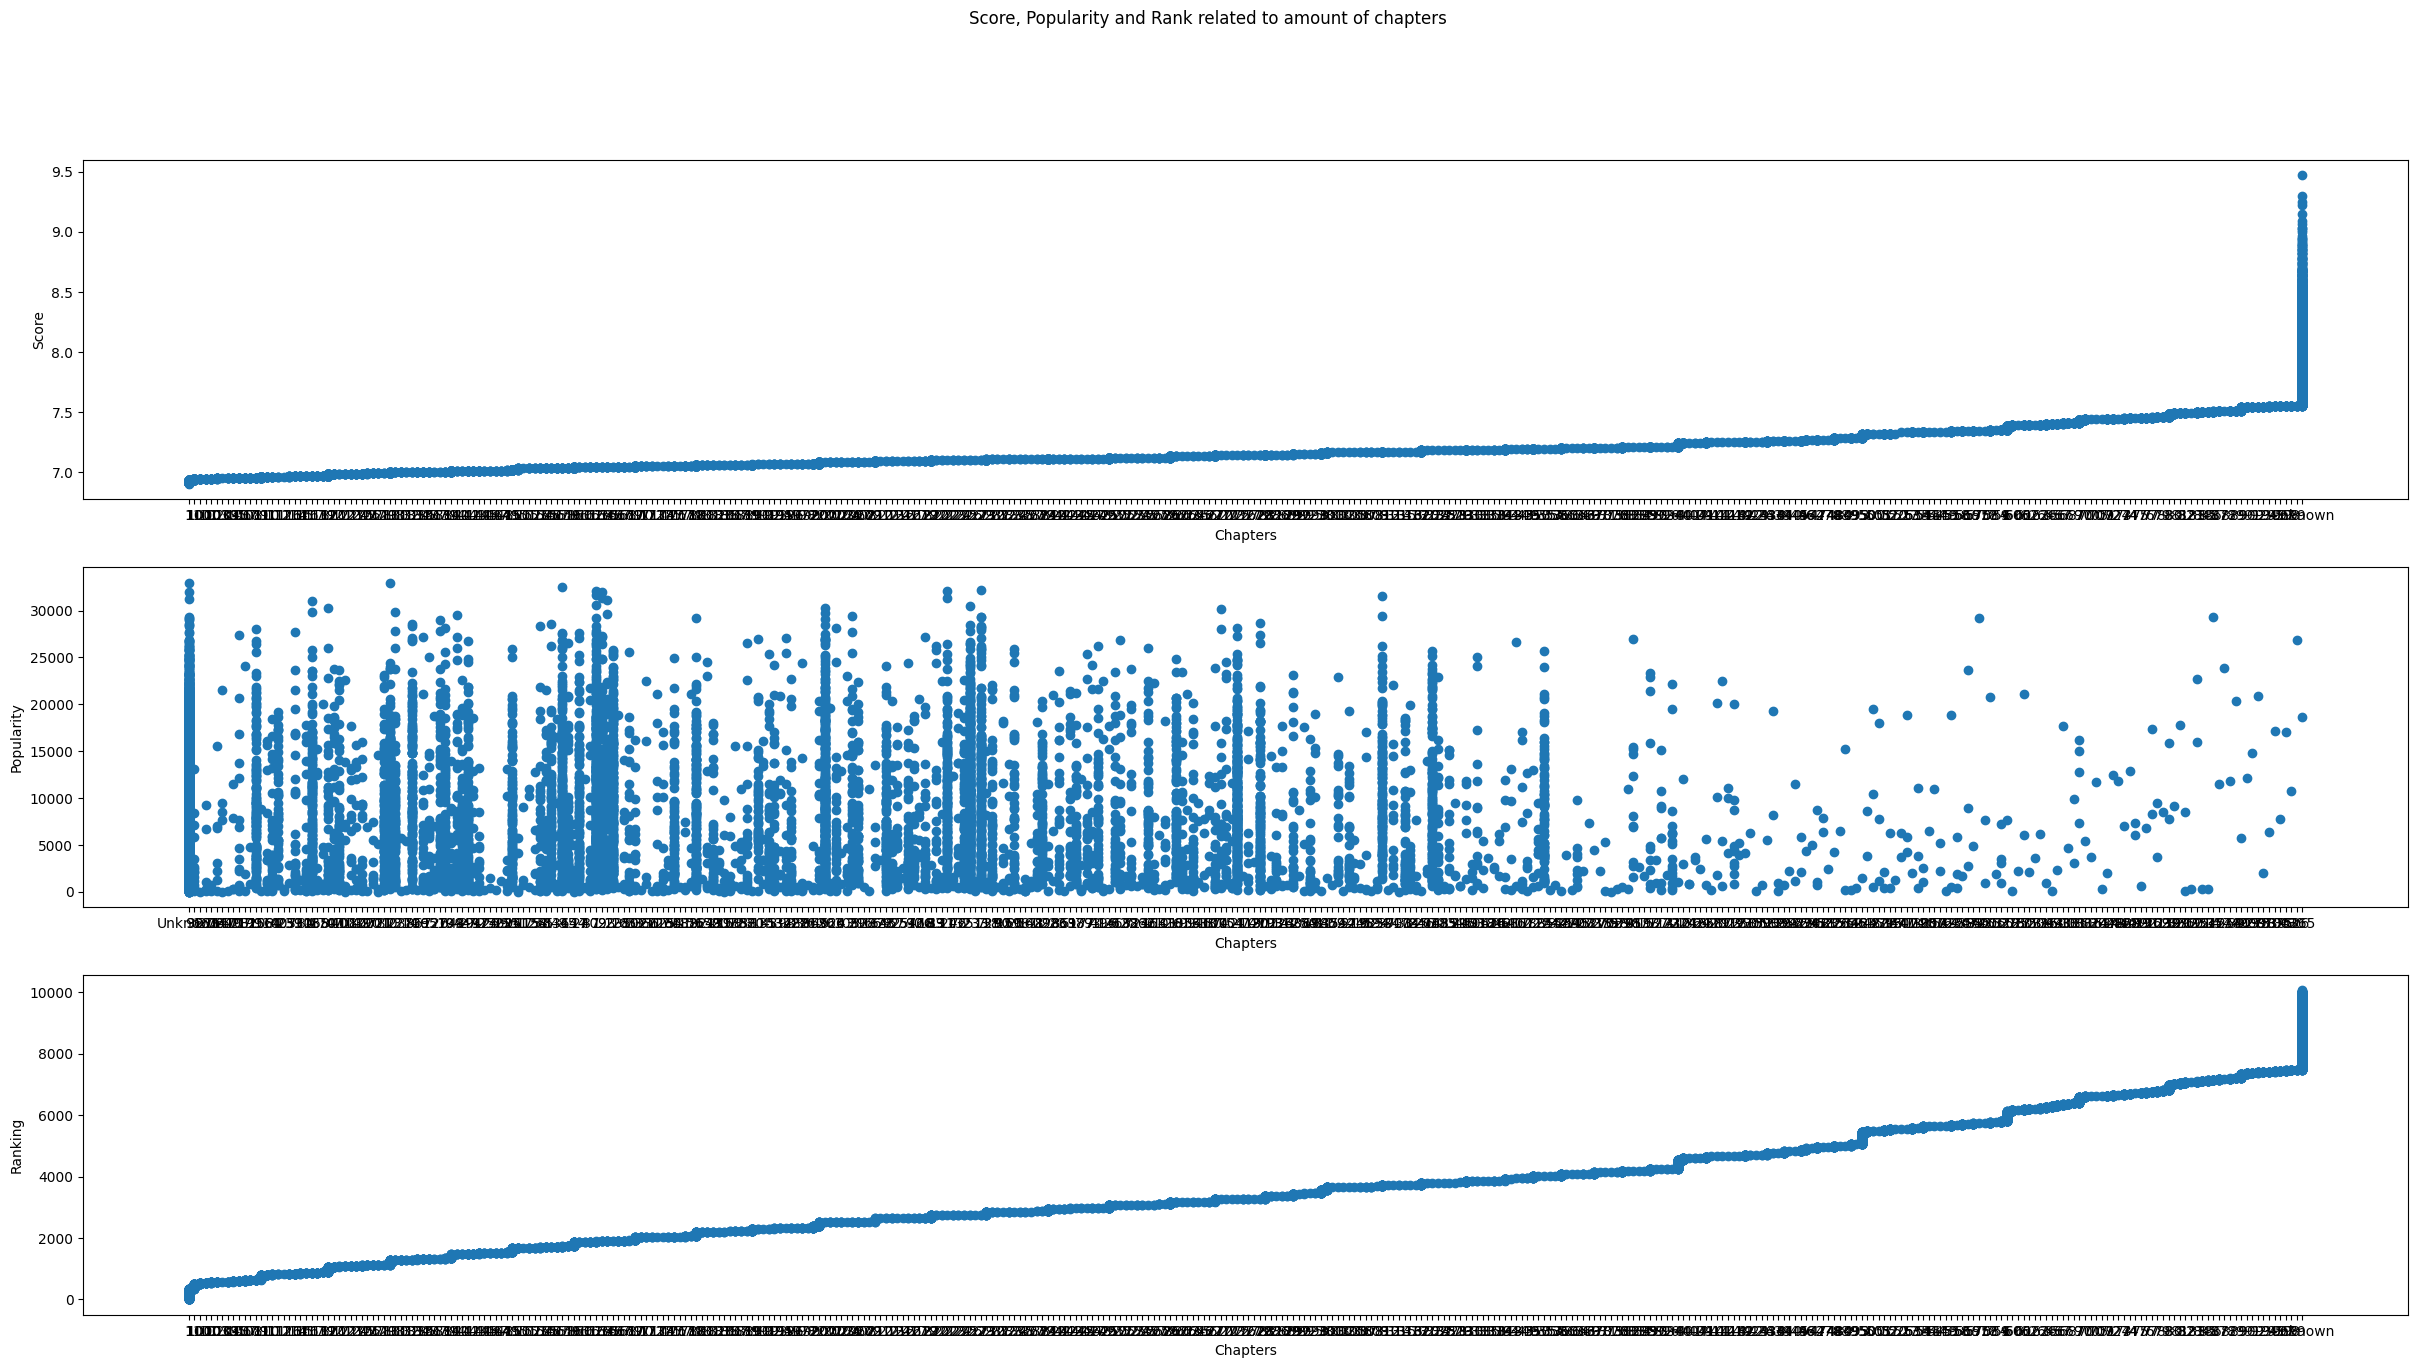

In [66]:
# Reading the dataset csv file into a pandas dataframe
df = pd.read_csv("manga.csv")

# The columns we are interested in
score = df.Score
popularity = df.Popularity
rank = df.Ranked
chapters = df.Chapters

# General data cleanup
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

# Remove everything below the 10% vote quantile to remove extremes
df = df[df.Vote >= df.Vote.quantile(0.1)]

# Remove everything above the 10% chapters quantile to remove extremes
df['Chapters'] = pd.to_numeric(df['Chapters'], errors='coerce') # Convert Chapters data column to numeric
df = df[df.Chapters <= df.Chapters.quantile(0.9)]

# ----- Plotting metrics against chapters -----
figure, axs = mpl.subplots(3, figsize=(30, 15))
figure.suptitle("Score, Popularity and Rank related to amount of chapters")

# Score-Chapters
score_chap = axs[0].scatter(chapters.sort_values(), score.sort_values())
axs[0].set_ylabel("Score")
axs[0].set_xlabel("Chapters")

# # Popularity - Chapters
# pop_chap = axs[1].scatter(chapters, popularity)
# axs[1].set_ylabel("Popularity")
# axs[1].set_xlabel("Chapters")

# # Ranking - Chapters
# rank_chap = axs[2].scatter(chapters, rank)
# axs[2].set_ylabel("Ranking")
# axs[2].set_xlabel("Chapters")
